<a href="https://colab.research.google.com/github/jdcast/dl-final-project/blob/main/CPC_Image_Sequences_3D_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Script to train CPC network on sequence of images using 3D encoder
 - network references: https://github.com/davidtellez/contrastive-predictive-coding/blob/master/train_model.py 
 - dataloader references: https://github.com/davidtellez/contrastive-predictive-coding/blob/master/data_utils.py and https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=_kN-xXH00mey

## Imports

In [1]:
import os
import pdb
import time
import random

%matplotlib inline
import torch as T
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import randrange
from random import choice
from random import uniform
from torchsummary import summary
from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from scipy.stats import entropy
import copy

from skimage import io

import itertools

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()

# Dataset 

## Mount Google Drive

In [2]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Mounted at /content/drive


## Data Directory

In [3]:
#address of data in google drive 
data_dir = "/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset"

## Display Sample of the Data

(538, 701, 3)


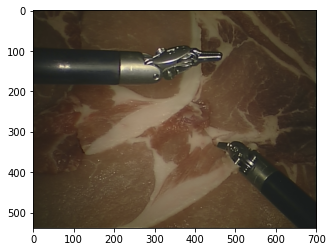

In [4]:
test_img_path = os.path.join(data_dir, "Video_01/images/000.png")
test_img = io.imread(test_img_path)
plt.imshow(test_img)
print(test_img.shape) #original img dimension

## Dataloader Architecture
 - returns sequences of image sequences
 - return shape: (terms+predict_terms, c, frames, h, w)

In [23]:
FRAMES_PER_VIDEO = 300

class ImageDataset(Dataset):
    """
    Image Dataset
    """

    def __init__(self, data_dir, op, batch_size, terms, frames_per_term, image_shape, transform=False, predict_terms=1, occlusion=False):
      """
      Args:
          input_dir: input data path to images and masks
          op: 'train' or 'test'
          batch_size: number of sequences per batch
          terms: number of past images in sequences (i.e. the terms in the sequence we train on)
          frames_per_term: number of frames per term (each term is a sequence of images)
          image_shape: tuple (h, w), shape to resize images to
          transform: boolean, whether to apply transformations
          predict_terms: number of future images in sequences to predict the embeddings of (i.e. the predictions by the RNN model)
      """
      assert terms > 0, 'number of past terms in sequence must be greater than 0'
      assert predict_terms > 0, 'number of future terms in sequence to predict must be greater than 0'
      assert batch_size > 0, 'batch size must be greater than 0'
      assert frames_per_term > 0, 'number of framers per term must be greater than 0'

      #  length of dataset is the number of sequences of image sequences (sentences) that can fit in our dataset
      try:
        if op == 'train':
            self.len = FRAMES_PER_VIDEO * 8 // ((terms + predict_terms)*frames_per_term) # train 8 videos each with 300 pictures
        elif op == 'val':
            self.len = FRAMES_PER_VIDEO * 2 // ((terms + predict_terms)*frames_per_term) # val 2 videos each with 300 pictures   
        elif op == 'test':
            self.len = FRAMES_PER_VIDEO * 4 // ((terms + predict_terms)*frames_per_term) # test 4 videos each with 300 pictures
        self.n_batches = self.len // batch_size
      except ValueError:
        print ('op should be train, val or test.')

      # self.frame = frame
      self.op = op # specify train or test 
      self.data_dir = data_dir
      self.transform = transform
      if occlusion:
          assert frames_per_term > 9, 'number of frames should be greater than 9 for occlusion to work'
      self.occlusion = occlusion
      self.occ_frames = 4 # Number of frames to occlude.
      self.occ_box_size = 50
      self.mask_num = 2 # Only 2 output class labels.

      self.batch_size = batch_size
      self.terms = terms
      self.predict_terms = predict_terms
      self.frames_per_term = frames_per_term
      self.image_shape = image_shape
      self.h = self.image_shape[0]
      self.w = self.image_shape[1]
      self.mask_value = {0:0, 1:255}
    
    def __len__(self):
        """
          for training: using videos from 01-8 each with 300 pics (8 * 300 img in total)
          for testing: using videos from 9-10 each with 300 pics (2 * 300 img in total)
          for testing: using videos from 11-14 each with 300 pics (4 * 300 img in total)
        """
        return self.len
    
    def __getitem__(self, idx):
        """
          returning corresponding img and mask from dataset folder 
        """
       
        if self.op == 'train':
          video_id = (idx * (self.terms + self.predict_terms)*self.frames_per_term) // 300 + 1 #returning the number part of video's name str (i.e. "Video_01"'s '01')
        elif self.op == 'val':
          video_id = (idx * (self.terms + self.predict_terms)*self.frames_per_term) // 300 + 9
        else:
          video_id = (idx * (self.terms + self.predict_terms)*self.frames_per_term) // 300 + 11
        video_name = str(video_id).zfill(2)
        img_dir = os.path.join(self.data_dir, "Video_" + video_name, "images/")
        mask_dir = os.path.join(self.data_dir, "Video_" + video_name, "ground_truth/")

        # determine if sample will be positive or negative 
        is_positive = random.uniform(0, 1) < 0.2

        # Compile the indices of our frames that will compose the sequence of sequences.  
        # The main idea is to stack all frames for each sequence together into one long sequence, process those frames with any required preprocessing, form a pytorch
        # tensor sequence from this sequence and then finally break up this long sequence into multiple sequences based on the desired sequence length.
        # 
        # choose random starting index for sequence from video
        # we have to be careful so as to make sure our required sequence length can be extracted i.e. if the sequence is chosen too close to the end of the video
        if is_positive: # must fit the previous and future terms
          sentence_label = 1
          start_idx = randrange(FRAMES_PER_VIDEO - (self.terms + self.predict_terms)*self.frames_per_term) + 1 # plus 1 since randrange doesn't include end in range (images are 0 indexed)
          frames = [start_idx + i for i in range((self.terms + self.predict_terms)*self.frames_per_term)]
        else: # only worry about previous terms since future terms don't have to be in sequence with previous terms
          sentence_label = 0
          start_idx = randrange(FRAMES_PER_VIDEO - self.terms*self.frames_per_term) + 1
          frames = [start_idx + i for i in range(self.terms*self.frames_per_term)]

          # add on random frames for the predict terms
          for j in range(self.predict_terms*self.frames_per_term):
            
            # don't choose one of the currently chosen frames
            term = choice([i for i in range(300) if i not in frames])
            frames.append(term)

        img, mask = torch.zeros((3, len(frames), self.image_shape[0], self.image_shape[1])), torch.zeros((2, len(frames), 256, 320))

        if self.occlusion:
          start = -1
          if np.random.random() > 0.6:
            start = np.random.randint(self.frames_per_term - self.occ_frames)

        # process frames
        for i in range(len(frames)):

            img_name = os.path.join(img_dir, str(frames[i]).zfill(3) + ".png")
            mask_name = os.path.join(mask_dir, str(frames[i]).zfill(3) + '.png')
            
            img_next = Image.open(img_name)
            mask_next = Image.open(mask_name)

            img_next = TF.resize(img_next, (self.image_shape[0], self.image_shape[1]), interpolation=TF.InterpolationMode.NEAREST)
            mask_next = TF.resize(mask_next, (self.image_shape[0], self.image_shape[1]), interpolation=TF.InterpolationMode.NEAREST)
            
            # Apply data augmentations, if any.
            if self.transform:
                img_next, mask_next = self.augment(img_next, mask_next)

            # occlusion
            if self.occlusion and (i % self.frames_per_term) >= start and (i % self.frames_per_term) < start + self.occ_frames:
                img_next, mask_next = self.occlude(img_next, mask_next)
            
            mask_next = np.array(mask_next)
            
            # Convert grey-scale label to one-hot encoding
            new_mask = np.zeros((self.image_shape[0], self.image_shape[1], self.mask_num))
            for idx in range(self.mask_num):
                new_mask[:, :, idx] = mask_next[:, :, 0] == self.mask_value[idx]

            # Transform to tensor
            img_next = TF.to_tensor(img_next)
            mask_next = TF.to_tensor(new_mask)
            
            img[:, i, :, :] = img_next
            mask[:, i, :, :] = mask_next

        # Break sequence into multiple sequences
        img = T.split(img, split_size_or_sections=self.frames_per_term, dim=1)
        mask = T.split(mask, split_size_or_sections=self.frames_per_term, dim=1)
        frames = T.split(T.tensor(frames), split_size_or_sections=self.frames_per_term, dim=0)

        # combined return lists into concatenated tensors so that they can be used during training
        img_t = T.unsqueeze(img[0], 0)
        mask_t = T.unsqueeze(mask[0], 0)
        frames_t = T.unsqueeze(frames[0], 0)
        for i in range(len(img)):
          if i > 0:
            img_seq = T.unsqueeze(img[i], 0)
            img_t = T.cat((img_t, img_seq), dim=0)

            mask_seq = T.unsqueeze(mask[i], 0)
            mask_t = T.cat((mask_t, mask_seq), dim=0)

            frames_seq = T.unsqueeze(frames[i], 0)
            frames_t = T.cat((frames_t, frames_seq), dim=0)

        return img_t, mask_t, sentence_label, frames_t

    def augment(self, img, mask):

        
        if np.random.random() > 0.5:

            # Random horizontal flipping
            if np.random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)

            # Random vertical flipping
            if np.random.random() > 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)

            # # Random brightness change
            # if np.random.random() > 0.67:
            #     img = TF.adjust_brightness(img, np.random.rand() + 0.5)

            # # Random gaussian blur
            # if np.random.random() > 0.8:
            #     img = TF.gaussian_blur(img, [5, 5])
        
        return img, mask

    def occlude(self, img, mask):

        img = np.array(img)
        tool_removed_img = np.where(mask, 0, img)

        min_size = min(self.h, self.w)
        if self.h == min_size:
          coord_h_low, coord_h_high = self.h // 2 - self.h // 3, self.h // 2 + self.h // 3
          coord_w_low, coord_w_high = self.w // 2 - self.h // 3, self.w // 2 + self.h // 3
          slack = self.h - coord_h_high
        else:
          coord_h_low, coord_h_high = self.h // 2 - self.w // 3, self.h // 2 + self.w // 3
          coord_w_low, coord_w_high = self.w // 2 - self.w // 3, self.w // 2 + self.w // 3
          slack = self.w - coord_w_high


        center_img = img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :]
        center_tool_removed_img = tool_removed_img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :]
        
        new_center = np.zeros(center_img.shape)
        
        # Flip
        flip = np.random.randint(3)
        if not flip: # horizontal_flip
          flipped_img = np.flip(img, 0)
          flipped_tool_removed_img = np.flip(tool_removed_img, 0)
        elif flip == 1: # vertical flip
          flipped_img = np.flip(img, 1)
          flipped_tool_removed_img = np.flip(tool_removed_img, 1)
        else: # both
          flipped_img = np.flip(img, (0, 1))
          flipped_tool_removed_img = np.flip(tool_removed_img, (0, 1))

        # Rotated center image to paste from.
        rot_center_img = np.rot90(center_img, 1, (0, 1))

        # Translate
        delta = np.random.randint(slack // 4, slack // 2)
        direction = np.random.randint(4)
        if not direction: # Towards bottom right
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low + delta, coord_w_low + delta, coord_h_high + delta, coord_w_high + delta
        elif direction == 1: # Towards top right
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low - delta, coord_w_low + delta, coord_h_high - delta, coord_w_high + delta
        elif direction == 1: # Towards bottom left
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low + delta, coord_w_low - delta, coord_h_high + delta, coord_w_high - delta
        else: # Towards top left
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low - delta, coord_w_low - delta, coord_h_high - delta, coord_w_high - delta

        transformed_center_img = flipped_img[coord_h_lowt:coord_h_hight, coord_w_lowt:coord_w_hight, :]
        transformed_center_tool_removed_img = flipped_tool_removed_img[coord_h_lowt:coord_h_hight, coord_w_lowt:coord_w_hight, :]

        center_new = np.where(center_tool_removed_img == transformed_center_tool_removed_img, rot_center_img, center_img)
        img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :] = center_new
        
        return img, mask

## Test Dataloaders

First sentence from a test batch...
torch.Size([5, 6, 3, 10, 256, 320]) torch.Size([5, 6, 2, 10, 256, 320]) torch.Size([5]) torch.Size([5, 6, 10])
Positive Sentence: 1


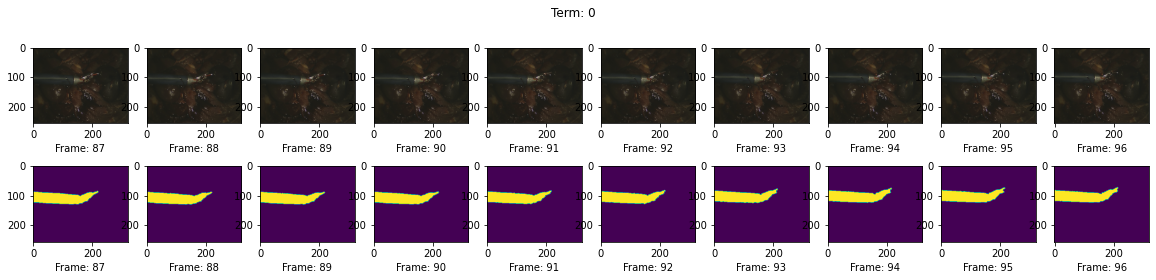

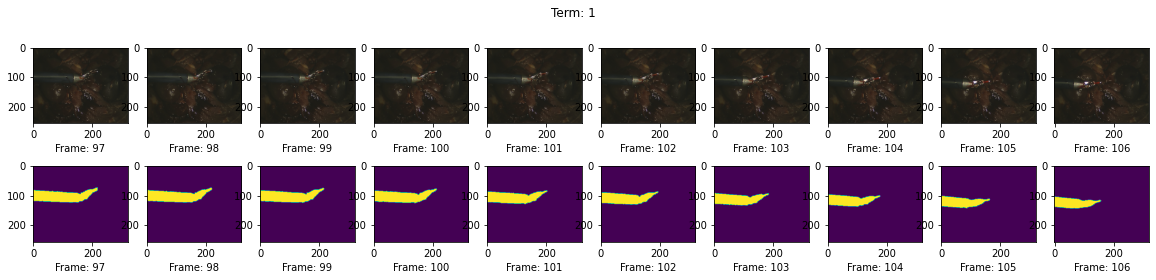

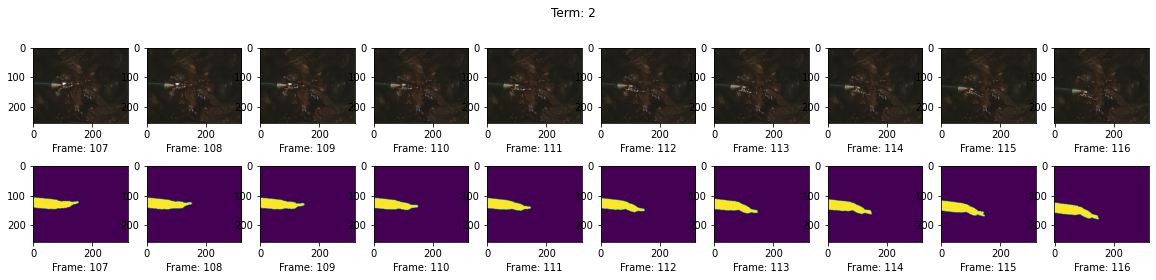

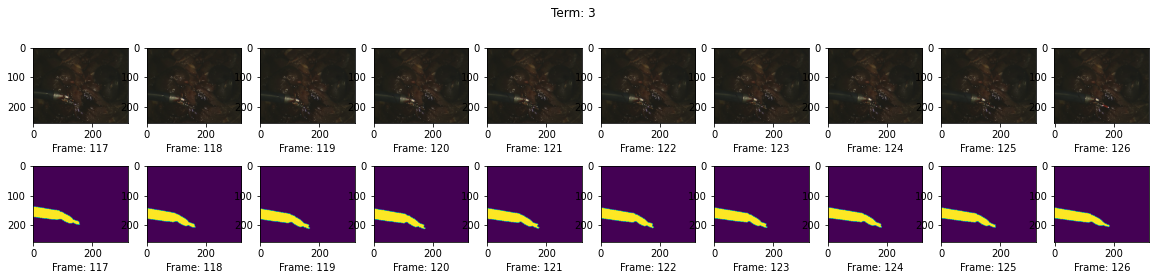

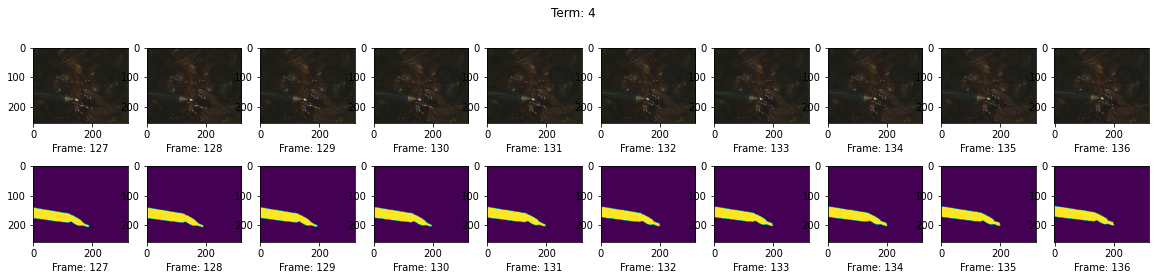

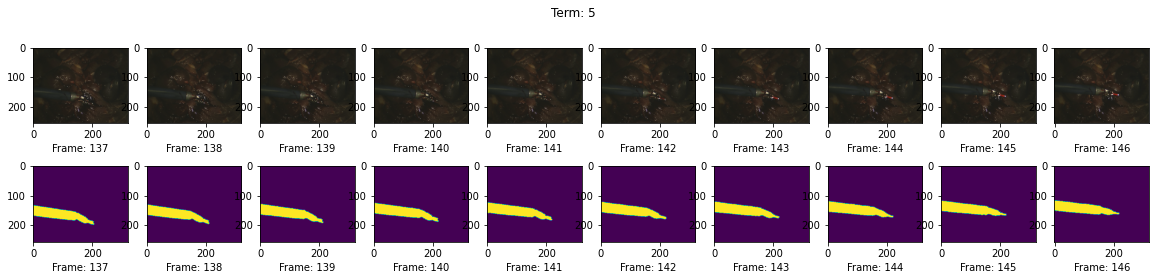

First sentence from a val batch...
torch.Size([5, 6, 3, 10, 256, 320]) torch.Size([5, 6, 2, 10, 256, 320]) torch.Size([5]) torch.Size([5, 6, 10])
Negative Sentence: 0


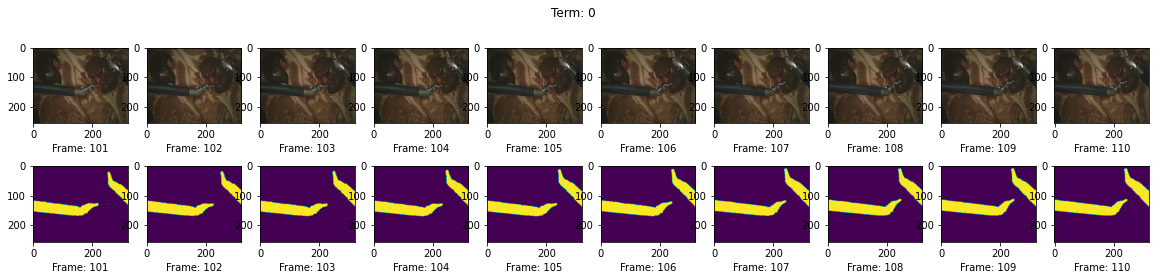

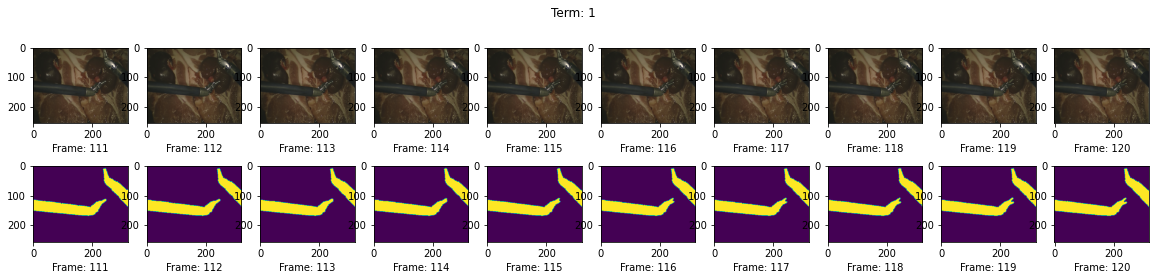

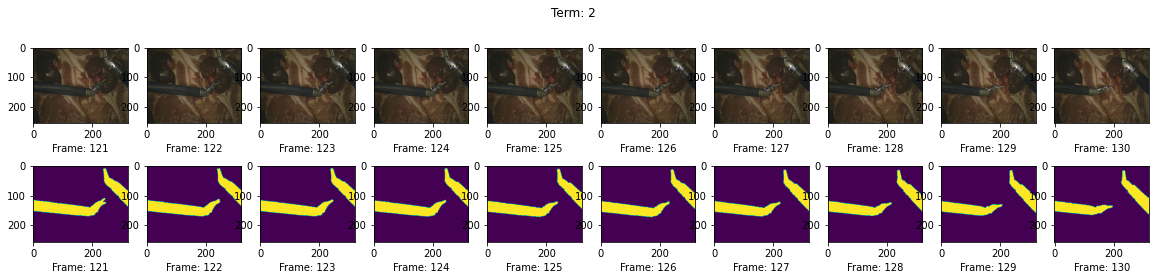

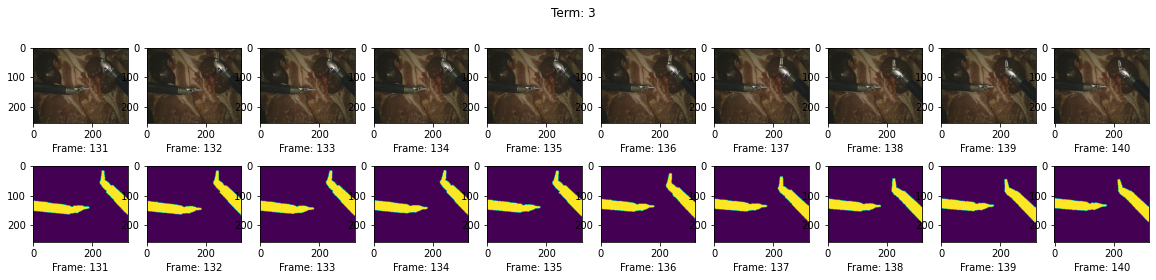

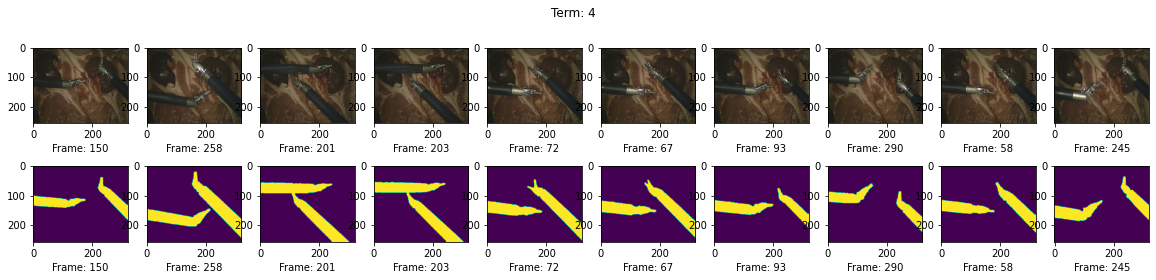

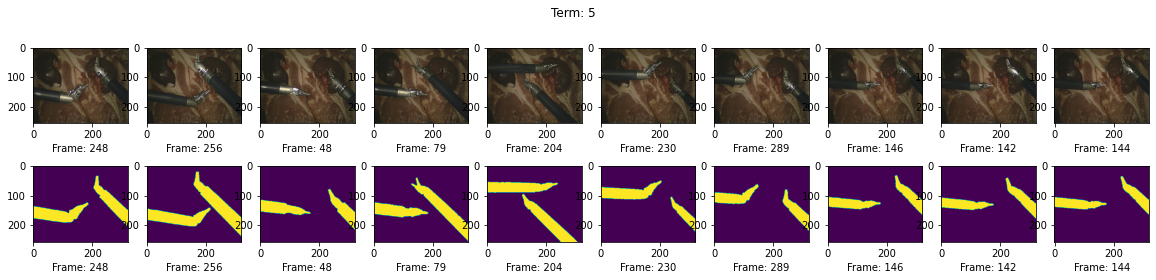

First sentence from a train batch...
torch.Size([5, 6, 3, 10, 256, 320]) torch.Size([5, 6, 2, 10, 256, 320]) torch.Size([5]) torch.Size([5, 6, 10])
Negative Sentence: 0


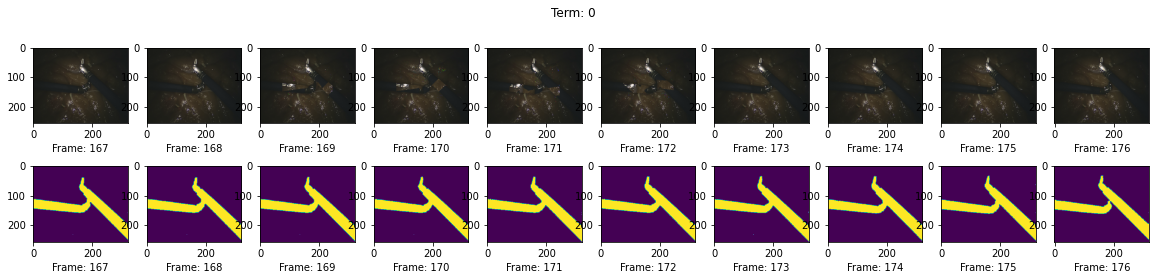

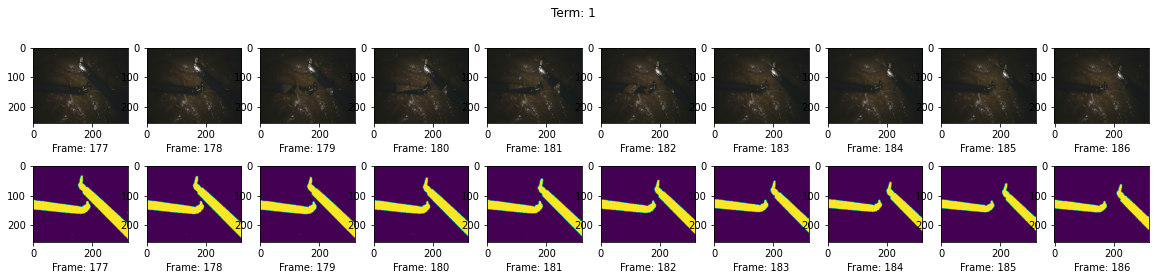

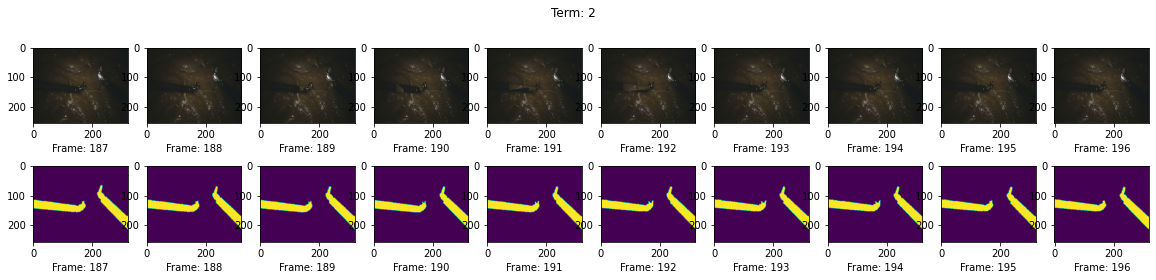

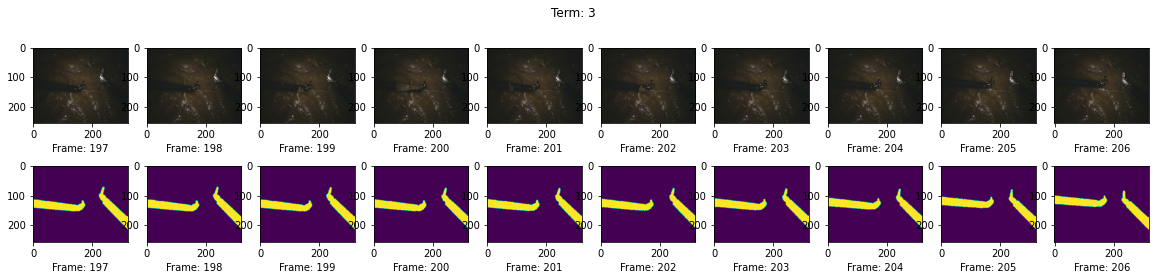

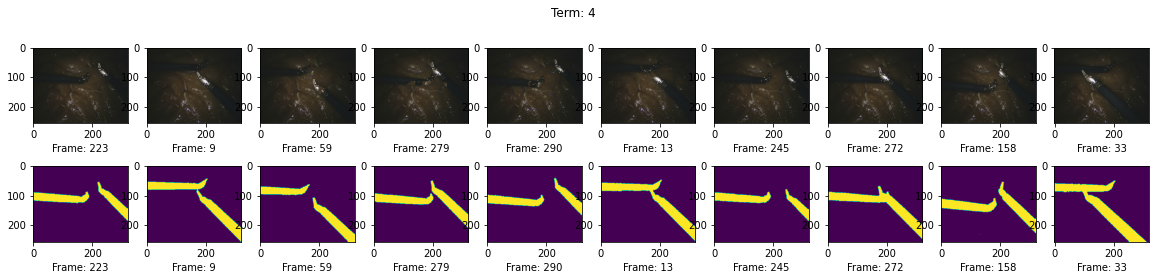

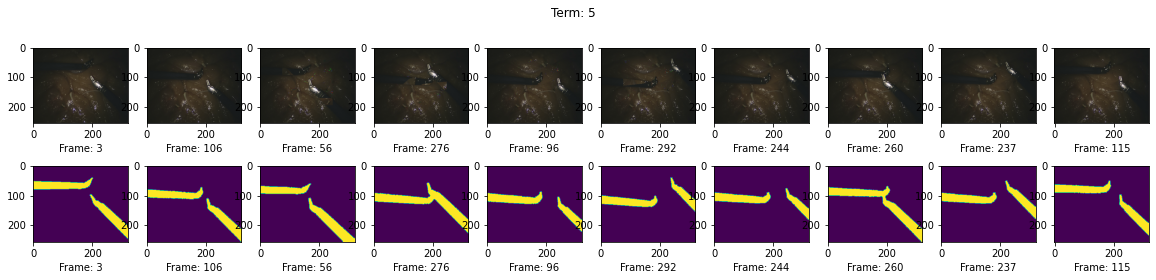

In [24]:
batch_size = 5
terms = 4
predict_terms = 2
frames_per_term = 10
image_shape = (256, 320)

train_dataset = ImageDataset(data_dir, op='train', batch_size=batch_size, terms=terms, frames_per_term=frames_per_term, 
                             image_shape=image_shape, transform=False, predict_terms=predict_terms, occlusion=True)
val_dataset = ImageDataset(data_dir, op='val', batch_size=batch_size, terms=terms, frames_per_term=frames_per_term, 
                           image_shape=image_shape, transform=False, predict_terms=predict_terms, occlusion=False)
test_dataset = ImageDataset(data_dir, op='test', batch_size=batch_size, terms=terms, frames_per_term=frames_per_term, 
                            image_shape=image_shape, transform=False, predict_terms=predict_terms, occlusion=False)

train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, num_workers=3)
val_dataloader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

train_imgs, train_masks, train_sentence_labels, train_frame_numbers = next(iter(train_dataloader))
val_imgs, val_masks, val_sentence_labels, val_frame_numbers = next(iter(val_dataloader))
test_imgs, test_masks, test_sentence_labels, test_frame_numbers = next(iter(test_dataloader))

# show first sentence from a batch from test dataloader
print("First sentence from a test batch...")
print(test_imgs.shape, test_masks.shape, test_sentence_labels.shape, test_frame_numbers.shape)
print("{}".format("Positive Sentence: 1" if test_sentence_labels[0].cpu().data == 1 else "Negative Sentence: 0"))
for k in range(terms+predict_terms):
  fig = plt.figure(figsize=(20, 4))
  columns = frames_per_term
  rows = 2

  for i in range(rows):
    for j in range(columns):
      if i == 0:
        image = torch.permute(test_imgs[0, k, :, j, :, :], (1, 2, 0)).cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      else:
        image = torch.argmax(test_masks[0][k], dim=0)[j].cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      plt.xlabel("Frame: {}".format(test_frame_numbers[0, k, j].cpu().numpy()))
  
  fig.suptitle("Term: {}".format(k))
  plt.show()

# show first sentence from a batch from val dataloader
print("First sentence from a val batch...")
print(val_imgs.shape, val_masks.shape, val_sentence_labels.shape, val_frame_numbers.shape)
print("{}".format("Positive Sentence: 1" if val_sentence_labels[0].cpu().data == 1 else "Negative Sentence: 0"))
for k in range(terms+predict_terms):
  fig = plt.figure(figsize=(20, 4))
  columns = frames_per_term
  rows = 2

  for i in range(rows):
    for j in range(columns):
      if i == 0:
        image = torch.permute(val_imgs[0, k, :, j, :, :], (1, 2, 0)).cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      else:
        image = torch.argmax(val_masks[0][k], dim=0)[j].cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      plt.xlabel("Frame: {}".format(val_frame_numbers[0, k, j].cpu().numpy()))
  
  fig.suptitle("Term: {}".format(k))
  plt.show()

# show first sentence from a batch from test dataloader
print("First sentence from a train batch...")
print (train_imgs.shape, train_masks.shape, train_sentence_labels.shape, train_frame_numbers.shape)
print("{}".format("Positive Sentence: 1" if train_sentence_labels[0].cpu().data == 1 else "Negative Sentence: 0"))
for k in range(terms+predict_terms):
  fig = plt.figure(figsize=(20, 4))
  columns = frames_per_term
  rows = 2

  for i in range(rows):
    for j in range(columns):
      if i == 0:
        image = torch.permute(train_imgs[0, k, :, j, :, :], (1, 2, 0)).cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      else:
        image = torch.argmax(train_masks[0][k], dim=0)[j].cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      plt.xlabel("Frame: {}".format(train_frame_numbers[0, k, j].cpu().numpy()))

  fig.suptitle("Term: {}".format(k))
  plt.show()

# Models

## Network Encoder
 - use encoder from 3D Vanilla UNet: https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=_kN-xXH00mey

In [36]:
# Encoder

## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding='same',
                   bias=True,
                   useBN=True):
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

def last_layer(dim_in,
               dim_out,
               kernel_size=3,
               stride=1,
               padding='same',
               bias=True,
               useBN=True):
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        )

class network_encoder(nn.Module):
  def __init__(self, useBN=True):
    super(network_encoder, self).__init__()

    # Downgrade stages
    if useBN:
      self.conv1 = nn.Sequential(
        nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
        nn.BatchNorm3d(32),
        nn.LeakyReLU(0.1))
    else:
      self.conv1 = nn.Sequential(
        nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
        nn.LeakyReLU(0.1))
    
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    self.last_layer = last_layer(256, 512, useBN=useBN)
    
    # Maxpool
    self.max_pool122 = nn.MaxPool3d(2, stride=(1, 2, 2))
    self.max_pool2 = nn.MaxPool3d(2)

    # weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()
        torch.nn.init.kaiming_uniform_(m.weight.data)
        
  def forward(self, inputs):
    """
    Forward pass
    """
    conv1_out = self.conv1(inputs)
    conv2_out = self.conv2(self.max_pool2(conv1_out))
    conv3_out = self.conv3(self.max_pool122(conv2_out))
    conv4_out = self.conv4(self.max_pool2(conv3_out))
    out = self.last_layer(self.max_pool2(conv4_out))

    return out

## Print Encoder Architecture

In [37]:
# image_shape = (512, 672)
image_shape = (256, 320)
frames_per_term = 10

encoder_model = network_encoder()
summary(encoder_model, (3, frames_per_term, image_shape[0], image_shape[1])) # dataloader provides batches of shape: (batch_size, terms+predict_terms, c, frames, h, w)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 10, 128, 160]           2,624
       BatchNorm3d-2     [-1, 32, 10, 128, 160]              64
         LeakyReLU-3     [-1, 32, 10, 128, 160]               0
         MaxPool3d-4        [-1, 32, 5, 64, 80]               0
            Conv3d-5        [-1, 64, 5, 64, 80]          55,360
       BatchNorm3d-6        [-1, 64, 5, 64, 80]             128
         LeakyReLU-7        [-1, 64, 5, 64, 80]               0
            Conv3d-8        [-1, 64, 5, 64, 80]         110,656
       BatchNorm3d-9        [-1, 64, 5, 64, 80]             128
        LeakyReLU-10        [-1, 64, 5, 64, 80]               0
        MaxPool3d-11        [-1, 64, 4, 32, 40]               0
           Conv3d-12       [-1, 128, 4, 32, 40]         221,312
      BatchNorm3d-13       [-1, 128, 4, 32, 40]             256
        LeakyReLU-14       [-1, 128, 4,

## Network Autoregressive
 - RNN
  - uses GRU

In [38]:
class network_autoregressive(nn.Module):
    # initializers
    def __init__(self, input_size, hidden_size=256):
      '''
      hidden_size: is a hyperparameter and should likely be a power of 2
      '''
      super(network_autoregressive, self).__init__()

      # GRU
      self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1)

    # forward method
    def forward(self, input):
      # we don't provide a hidden state, by default it's all zeros
      out, h = self.gru(input)

      return out, h

~## Print RNN Architecture~ not clear how to use summary() with GRU

In [39]:
# rnn_model = network_autoregressive(code_size=10, hidden_size=256)
# summary(rnn_model, (1, 10))

In [40]:
# simple GRU test to look at output

# latent space dimensionality (e.g. dimensionality of output space of encoder)
# set by flattening output of encoder in 1D vector: 512x16x21
code_size = 512*16*21

# number of features in hidden state of RNN
hidden_size = 256

# number of input frames
terms = 4

# number of future frames to predict
predict_terms = 2

batch_size = 5

rnn = nn.GRU(code_size, hidden_size, 1, batch_first=True)
input = torch.randn(batch_size, terms + predict_terms, code_size)
h0 = torch.randn(1, batch_size, hidden_size)
output, hn = rnn(input, h0)
print(output.shape)

torch.Size([5, 6, 256])


## Lambda Layer 
 - analogous to keras.layers.Lambda 
- https://discuss.pytorch.org/t/how-to-implement-keras-layers-core-lambda-in-pytorch/5903

In [41]:
class Lambda(nn.Module):
    def __init__(self, lambd):
        super(Lambda, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

## Network Prediction  
- Define mapping between context (produced by RNN) and multiple, future embedding predictions

In [42]:
class network_prediction(nn.Module):

    ''' Define the context mapping to embedding vectors of future frames '''
    def __init__(self, hidden_size, code_size, terms, predict_terms):
      super(network_prediction, self).__init__()

      # linear layer for each output
      self.linears = nn.ModuleList()
      for i in range(predict_terms):
        # original code used a "linear" activation so we omit an activation on the layer
        self.linears.append(nn.Linear(in_features=terms*hidden_size, out_features=code_size))

    def forward(self, context):
      # squash all but batch dimension so will work with linear layers
      context = context.contiguous().view(context.size(0), -1)

      # return a tensor so downstream CPCLayer's dot product works
      outputs = self.linears[0](context)
      outputs = T.unsqueeze(outputs, 1) # we will stack along the temporal dimension

      for i, l in enumerate(self.linears):
        if i > 0:
          next_output = T.unsqueeze(l(context), 1)
          outputs = T.cat((outputs, next_output), dim=1)

      return outputs

## TimeDistributed Layer to mimic Kera's TimeDistributed layer: 
- https://stackoverflow.com/questions/62912239/tensorflows-timedistributed-equivalent-in-pytorch

In [43]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(2), x.size(3), x.size(4), x.size(5))  # (batch_size * terms, c, frames, h, w)

        y = self.module(x_reshape) # shape: [batch_size * terms, 512, 1, 16, 21] 
        y = y.squeeze(2)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-3), y.size(-2), y.size(-1))  # (batch_size, terms, 512, 16, 21)
        else:
            y = y.view(-1, x.size(1), y.size(-3), y.size(-2), y.size(-1))  # (terms, batch_size, 512, 16, 21)

        return y

## CPCLayer
 - Computes dot product between true and predicted embedding vectors

In [44]:
class CPCLayer(nn.Module):
  def __init__(self, **kwargs):
    super(CPCLayer, self).__init__(**kwargs)

  def forward(self, y_preds, y_encoded):
    ''' 
    y_preds: predictions of frames corresponding to predict_terms
    y_encoded: encoded gt frames corresponding to predict_terms
    '''
    dot_product = T.mean(y_encoded*y_preds, axis=-1)
    dot_product = T.mean(dot_product, axis=-1) # average along the temporal dimension

    # convert to probabilities
    dot_product_probs = T.sigmoid(dot_product) 

    return dot_product_probs
  

## Network CPC
TODO

In [45]:
class network_cpc(nn.Module):
  ''' 
  Define the CPC network combining encoder and autoregressive model 
  
  predict_terms: number of future images in sequences to predict the embeddings of (i.e. the predictions by the RNN model)
  code_size: latent space dimensionality (e.g. dimensionality of output space of encoder)
  '''

  def __init__(self, terms, predict_terms, code_size, hidden_size):
    super(network_cpc, self).__init__()
    
    self.encoder_model = network_encoder()
    self.timeDistributed_encoder = TimeDistributed(self.encoder_model, batch_first=True)
    self.network_autoregressive = network_autoregressive(input_size=code_size, hidden_size=hidden_size)
    self.network_prediction = network_prediction(hidden_size=hidden_size, code_size=code_size, terms=terms, predict_terms=predict_terms)
    self.cpcLayer = CPCLayer()

  def forward(self, x, y):
    x_encoded = self.timeDistributed_encoder(x)
    x_encoded = T.flatten(x_encoded, start_dim=2) # flatten x_encoded from [batch_size, terms+predict_terms, x, y, z] to [batch_size, terms+predict_terms, x*y*z] for GRU model
    context, hidden_state = self.network_autoregressive(x_encoded)
    y_preds = self.network_prediction(context)
    y_encoded = self.timeDistributed_encoder(y)
    y_encoded = T.flatten(y_encoded, start_dim=2)
    dot_product_probs = self.cpcLayer(y_preds, y_encoded)

    return dot_product_probs

In [46]:
# scratch work

temp = torch.randn(3, 4, 1, 5, 6)
temp = temp.squeeze(2)
print(temp.shape)
temp = T.flatten(temp, start_dim=1)
print(temp.shape)

torch.Size([3, 4, 5, 6])
torch.Size([3, 120])


# Train

## Evaluation Harness

In [51]:
def eval(terms, verbose = 1, loader=None, ltype="", model=None, loss_metric=None):
    correct = 0
    num_batches = 0
    loss_sum = 0
    num_samples = 0
    for i, (images, masks, sentence_labels, frame_numbers) in enumerate(loader):
        print("Eval -> {} Batch: {}".format(ltype, i))

        sentence_labels = sentence_labels.float()

        # permute the time and channel dimensions for easier handling during model inference
        # dataloader returns batches in shape: [batch_size, channels, time, height, width] but we would like [batch_size, time, channels, height, width]
        # images = torch.permute(images, (0, 2, 1, 3, 4))

        # split the images into the their respective terms and predict_terms groupings
        images_terms = images[:, :terms, :, :, :, :] # terms
        images_predict_terms = images[:, terms:, :, :, :, :] # predict_terms

        if gpu_boole:
          images_terms = images_terms.cuda()
          images_predict_terms = images_predict_terms.cuda()
          sentence_labels = sentence_labels.cuda()
        
        sentence_preds = model(images_terms, images_predict_terms)

        # threshold predictions to binary values
        sentence_preds_thresh = (sentence_preds > 0.5).float()

        num_samples += sentence_labels.size(0)
        num_batches += 1
        correct += (sentence_preds_thresh.float() == sentence_labels.float()).sum()
        loss = loss_metric(sentence_preds, sentence_labels)
        loss_sum += loss.detach()
        
    if verbose:
        print("{} accuracy: {}".format(ltype, (100.0 * correct / num_samples)))
        print("{} loss: {}".format(ltype, (loss_sum.cpu().data.numpy().item() / num_batches)))

    return 100.0 * correct / num_samples, loss_sum.cpu().data.numpy().item() / num_batches

## Train Harness

In [52]:
def train(epochs, 
          batch_size, 
          output_dir, 
          code_size, 
          image_shape, 
          lr=1e-4, 
          terms=4, 
          predict_terms=4, 
          frames_per_term=10, 
          hidden_size=256, 
          verbose=1, 
          save_checkpoints=1,
          apply_train_transforms=0):
  '''
  epochs: number of epochs to train 
  batch_size: batch size to use
  output_dir: directory to hold saved models and checkpoints
  code_size: length of embedding vector (i.e. output space of encoder)
  image_shape: (h,w) of images to be resized to
  lr: learning rate
  terms: number of terms for autoregressive model to ingest
  predict_terms: number of terms for autoregressive model to predict embedding vectors for
  frames_per_term: number of images per term in the sentence
  hidden_size: length of hidden vector of autoregressive model
  verbose: 0 or 1, 0 = quiet, 1 = print
  '''
  # Data
  train_dataset = ImageDataset(data_dir, op='train', 
                               batch_size=batch_size, 
                               terms=terms, 
                               frames_per_term=frames_per_term, 
                               image_shape=image_shape, 
                               transform=True if apply_train_transforms > 0 else False, 
                               predict_terms=predict_terms,
                               occlusion=True)
  val_dataset = ImageDataset(data_dir, op='val', 
                             batch_size=batch_size, 
                             terms=terms, 
                             frames_per_term=frames_per_term, 
                             image_shape=image_shape, 
                             transform=False, 
                             predict_terms=predict_terms,
                             occlusion=False)
  test_dataset = ImageDataset(data_dir, op='test', 
                              batch_size=batch_size, 
                              terms=terms, 
                              frames_per_term=frames_per_term, 
                              image_shape=image_shape, 
                              transform=False, 
                              predict_terms=predict_terms,
                              occlusion=False)

  print("Number of sentences (sequences of image sequences) in train dataset: {}".format(len(train_dataset)))
  print("Number of sentences (sequences of image sequences) in val dataset: {}".format(len(val_dataset)))
  print("Number of sentences (sequences of image sequences) in test dataset: {}".format(len(test_dataset)))

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  # Model
  model = network_cpc(terms=terms, predict_terms=predict_terms, code_size=code_size, hidden_size=hidden_size)
  summary(model, [(terms, 3, frames_per_term, image_shape[0], image_shape[1]), (predict_terms, 3, frames_per_term, image_shape[0], image_shape[1])]) # model summary needs both inputs specified

  # Optimizer, Learning Rate Scheduler, Loss
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=1/3, patience=2, min_lr=1e-4)
  lr_metric = 0 # used for learning rate policy "plateau"
  loss_metric = nn.BCELoss()

  val_loss_epoch_store = []
  train_loss_epoch_store = []
  val_acc_epoch_store = []
  train_acc_epoch_store = []

  print("Starting Training")
  #training loop:
  for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (train_imgs, train_masks, train_sentence_labels, train_frame_numbers) in enumerate(train_dataloader):
      print("Train -> Batch: {}".format(i+1))
      print(train_imgs.shape)
      print(train_sentence_labels.shape)
      print(train_frame_numbers)

      train_sentence_labels = train_sentence_labels.float()

      # permute the time and channel dimensions for easier handling during model inference
      # dataloader returns batches in shape: [batch_size, terms+predict_terms, channels, frames_per_term, height, width] but we would like [batch_size, time, channels, height, width]
      # train_imgs = torch.permute(train_imgs, (0, 2, 1, 3, 4))

      # split the images into the their respective terms and predict_terms groupings
      train_imgs_terms = train_imgs[:, :terms, :, :, :, :] # terms
      train_imgs_predict_terms = train_imgs[:, terms:, :, :, :, :] # predict_terms

      if gpu_boole:
        train_imgs_terms = train_imgs_terms.cuda()
        train_imgs_predict_terms = train_imgs_predict_terms.cuda()
        train_sentence_labels = train_sentence_labels.cuda()

      #loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      sentence_preds = model.forward(train_imgs_terms, train_imgs_predict_terms)
      loss = loss_metric(sentence_preds, train_sentence_labels)
      loss.backward()
                    
      ##performing parameter update:
      optimizer.step()

    ##performing lr update
    scheduler.step(lr_metric)

    if epoch % 1 == 0:
      print("Epoch",epoch+1,':')
      print("LR: {}".format(optimizer.param_groups[0]['lr'])) # ReduceLROnPlateau doesn't have get_last_lr() attribute: https://discuss.pytorch.org/t/shouldnt-reducelronplateau-super-optimizer-in-its-init/89390
    
    # validation
    model.eval()
    with torch.no_grad():
      train_acc, train_loss = eval(terms=terms, verbose=verbose, loader=train_dataloader, ltype="Train", model=model, loss_metric=loss_metric)
      val_acc, val_loss = eval(terms=terms, verbose=verbose, loader=val_dataloader, ltype="Val", model=model, loss_metric=loss_metric)
    model.train()

    val_loss_epoch_store.append(val_loss)
    train_loss_epoch_store.append(train_loss)
    val_acc_epoch_store.append(val_acc.cpu().data.numpy().item())
    train_acc_epoch_store.append(train_acc.cpu().data.numpy().item())

    # save checkpoint
    if save_checkpoints > 0:
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss_metric,
          }, os.path.join(output_dir, 'cpc_images_network_epoch_{}_ckpt.pth'.format(epoch+1)))

    time2 = time.time() #timekeeping
    if epoch % 1 == 0:
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      print()

  ## Plotting epoch-wise train/val loss curves
  plt.plot(train_loss_epoch_store, '-o', label = 'train_loss', color = 'blue')
  plt.plot(val_loss_epoch_store, '-*', label = 'val_loss', color = 'red')
  plt.xlabel('Epoch Number')
  plt.title('Train and Validation Loss At Last Epoch')
  plt.legend()
  fig = plt.gcf()
  plt.show()
  fig.savefig(os.path.join(output_dir, "train_val_loss"))

  ## Plotting epoch-wise train/val accuracy curves
  plt.plot(train_acc_epoch_store, '-o', label = 'train_acc', color = 'blue')
  plt.plot(val_acc_epoch_store, '-*', label = 'val_acc', color = 'red')
  plt.xlabel('Epoch Number')
  plt.title('Train and Validation Accuracy At Last Epoch')
  plt.legend()
  fig = plt.gcf()
  plt.show()
  fig.savefig(os.path.join(output_dir, "train_val_acc"))

  # Evaluate model on test dataset
  model.eval()
  with torch.no_grad():
    test_acc, test_loss = eval(terms=terms, verbose=verbose, loader=test_dataloader, ltype="Test", model=model, loss_metric=loss_metric)
  model.train()

  ## save entire model, doesn't seem possible to save just the encoder: https://discuss.pytorch.org/t/save-part-of-the-model/28519
  torch.save(model.state_dict(), os.path.join(output_dir, 'cpc_images_network.pth'))

  # save just encoder
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.encoder_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss_metric,
      }, os.path.join(output_dir, 'cpc_images_encoder.pth'))

  return train_loss_epoch_store, val_loss_epoch_store, test_loss, train_acc_epoch_store, val_acc_epoch_store, test_acc, model

## Start Training

Number of sentences (sequences of image sequences) in train dataset: 80
Number of sentences (sequences of image sequences) in val dataset: 20
Number of sentences (sequences of image sequences) in test dataset: 40
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 10, 128, 160]           2,624
            Conv3d-2     [-1, 32, 10, 128, 160]           2,624
       BatchNorm3d-3     [-1, 32, 10, 128, 160]              64
       BatchNorm3d-4     [-1, 32, 10, 128, 160]              64
         LeakyReLU-5     [-1, 32, 10, 128, 160]               0
         LeakyReLU-6     [-1, 32, 10, 128, 160]               0
         MaxPool3d-7        [-1, 32, 5, 64, 80]               0
         MaxPool3d-8        [-1, 32, 5, 64, 80]               0
            Conv3d-9        [-1, 64, 5, 64, 80]          55,360
           Conv3d-10        [-1, 64, 5, 64, 80]          55,360
      BatchNorm3d-

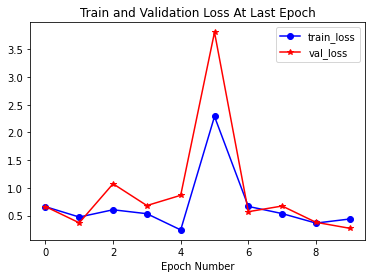

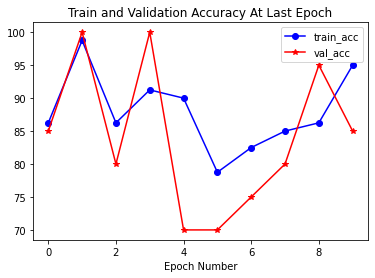

Eval -> Test Batch: 0
Eval -> Test Batch: 1
Eval -> Test Batch: 2
Eval -> Test Batch: 3
Eval -> Test Batch: 4
Eval -> Test Batch: 5
Eval -> Test Batch: 6
Eval -> Test Batch: 7
Test accuracy: 82.5
Test loss: 1.098501443862915


In [53]:
# hyperparameters
epochs=10 
batch_size=5 
output_dir=os.path.join('/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/runs/cpc_3d_encoder', "{}".format(time.time()).replace('.', '_')) # timestamp the run
# code_size=512*16*21, # output shape of encoder is [512, 1, 16, 21] (we squash the 2nd dimension)
code_size=512*8*10 # output shape of encoder is [512, 1, 8, 10] (we squash the 2nd dimension)
lr=1e-4 
terms=2 
predict_terms=1 
frames_per_term=10
hidden_size=256
#  image_shape=(512, 672),
image_shape=(256, 320) 
verbose=1
save_checkpoints=0
apply_train_transforms=1

# create output directory
os.mkdir(output_dir)

# write hyperparameters to .txt file
with open(os.path.join(output_dir, "config.txt"), "a") as f:
  f.write("dataset: {}\n".format(data_dir))
  f.write("epochs: {}\n".format(epochs)) 
  f.write("batch_size: {}\n".format(batch_size))
  f.write("output_dir: {}\n".format(output_dir))
  f.write("code_size: {}\n".format(code_size))
  f.write("lr: {}\n".format(lr))
  f.write("terms: {}\n".format(terms)) 
  f.write("predict_terms: {}\n".format(predict_terms)) 
  f.write("frames_per_term: {}\n".format(frames_per_term))
  f.write("hidden_size: {}\n".format(hidden_size))
  f.write("image_shape: {}\n".format(image_shape)) 
  f.write("verbose: {}\n".format(verbose))
  f.write("save_checkpoints: {}\n".format(save_checkpoints))
  f.write("apply_train_transforms: {}\n".format(apply_train_transforms))

res = train(epochs=epochs, 
            batch_size=batch_size, 
            output_dir=output_dir, 
            code_size=code_size, 
            lr=lr, 
            terms=terms, 
            predict_terms=predict_terms, 
            frames_per_term=frames_per_term,
            hidden_size=hidden_size,
            image_shape=image_shape, 
            verbose=verbose,
            save_checkpoints=save_checkpoints)

# write final train/val/test loss/acc to file
with open(os.path.join(output_dir, "final_loss_acc.txt"), "a") as f:
  f.write("Train Loss: {}\n".format(res[0][-1]))
  f.write("Val Loss: {}\n".format(res[1][-1]))
  f.write("Test Loss: {}\n".format(res[2]))
  f.write("Train Acc: {}\n".format(res[3][-1]))
  f.write("Val Acc: {}\n".format(res[4][-1]))
  f.write("Test Acc: {}\n".format(res[5]))